In [1]:
from natsort import natsorted
import cv2

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from natsort import natsorted
#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorboard

In [2]:
monkey_colours = ([])
for i in range(300):
    colour = tuple(np.random.randint(255,size = 3))
    monkey_colours.append(colour)

In [3]:
monk = {k:v for k,v in enumerate(monkey_colours)}

In [4]:
seq_colours = []
for i in range(300):
    a = i
    b = i
    c = i
    col = tuple((a,b,c))
    seq_colours.append(col)

In [5]:
sequential_cols = {k:v for k,v in enumerate(seq_colours)}

In [6]:

def rgb_to_onehot(rgb_image, colormap = sequential_cols):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    #print(rgb_image.shape)
    num_classes = len(colormap)
    colors = np.unique(rgb_image)
    #print(colors)
    colors = {k:v for k,v in enumerate(colors)}
    #print(colors)
    shape = rgb_image.shape[:2]+(num_classes,)
    #print(shape)
    #colors = {k:v for k,v in enumerate(np.unique(rgb_image))}
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        #print('i is: ', i)
        #print('cls is: ', cls)
        #encoded_image[:,:,i] = np.where(rgb_image==colormap[i],encoded_image[:,:,i],colormap[cls]).reshape(shape[:2])
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        #print(rgb_image.shape)
        #encoded_image[:,:,i] = np.argmax(encoded_image[:,:,i])
        #encoded_image[:,:,i] = np.where(encoded_image[:,:,i]== 1,encoded_image[:,:,i],255)
        #encoded_image = 1-encoded_image
    return encoded_image.astype(np.uint8)


def onehot_to_rgb(onehot, colormap = monk):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    
    single_layer = np.argmax(onehot, axis=2)
    #print(single_layer)
    output = np.zeros(onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        #print(k)
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [7]:
frame_train_args = dict(rescale = 1./255)
mask_train_args = dict()
zbuff_train_args = dict(rescale = 1./255)
l_train_gen = ImageDataGenerator(**frame_train_args)
r_train_gen = ImageDataGenerator(**frame_train_args)
zbuff_train_gen = ImageDataGenerator(**zbuff_train_args)
target_train_gen = ImageDataGenerator(**mask_train_args)



In [8]:
def StereoDepthGenNovel(batch_size = 8, seed = 22, target_size = (224,224)):  ## Two Inputs, two outputs

      data_path = 'GeneratorData/'
        
      left_gen = l_train_gen.flow_from_directory('MonkaaImages/Images/left/',batch_size = batch_size,
                                           target_size = target_size, shuffle = True,
                                           seed = 5)
  
      right_gen = r_train_gen.flow_from_directory('MonkaaImages/Images/right/', batch_size= batch_size,
                                            target_size = target_size, shuffle = True,
                                            seed = 5)
      depth_gen = zbuff_train_gen.flow_from_directory('MonkaaImages/Depth/left/', batch_size = batch_size,
                                                     target_size = target_size, shuffle = True, color_mode = 'grayscale',
                                                     seed = 5)
    
  
      left_mask = target_train_gen.flow_from_directory('MonkaaImages/Object_index/left/', batch_size = batch_size,
                                                  target_size = target_size, shuffle = True,
                                                  seed = 5)
  
      right_mask = target_train_gen.flow_from_directory('MonkaaImages/Object_index/right/', batch_size = batch_size,
                                                  target_size = target_size, shuffle = True,
                                                  seed = 5)
  
      while True:
        left = left_gen.next()
        right = right_gen.next()
        depth= depth_gen.next()
        left_target = left_mask.next()
        right_target = right_mask.next()
        #left = [noisy(left[0][x,:,:,:]) for x in range(left[0].shape[0])]
        #right = [noisy(right[0][x,:,:,:]) for x in range(right[0].shape[0])]
        l_mask = [rgb_to_onehot(left_target[0][x,:,:,:]) for x in range(left_target[0].shape[0])]
        r_mask = [rgb_to_onehot(right_target[0][x,:,:,:]) for x in range(right_target[0].shape[0])]

        yield [np.asarray(left[0]),np.asarray(right[0])], [np.asarray(l_mask),np.asarray(r_mask),np.asarray(depth[0])]


In [9]:

# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [10]:
def stereoDepthNet():   
        with tf.name_scope('layer'):
            n_filters =16
            left_in = Input(shape = (224,224,3),name = 'left_in')
            right_in = Input(shape = (224,224,3),name = 'right_in')

            l_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'left_conv1')(left_in)
            l_conv1 = BatchNormalization()(l_conv1)
            l_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_conv1)
            l_conv2 = BatchNormalization()(l_conv2)
            l_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv2)

            l_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_pool1)
            l_conv3 = BatchNormalization()(l_conv1)
            l_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_conv3)
            l_conv4 = BatchNormalization()(l_conv2)
            l_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv4)

            l_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_pool2)
            l_conv5 = BatchNormalization()(l_conv5)
            l_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_conv5)
            l_conv6 = BatchNormalization()(l_conv6)
            l_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv6)

            l_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_pool3)
            l_conv7 = BatchNormalization()(l_conv7)
            l_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_conv7)
            l_conv8 = BatchNormalization()(l_conv8)
            l_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv8)

            l_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_pool4)
            l_conv9 = BatchNormalization()(l_conv9)
            l_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_conv9)
            l_conv10 = BatchNormalization()(l_conv10)


            r_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'right_conv1')(right_in)
            r_conv1 = BatchNormalization()(r_conv1)
            r_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_conv1)
            r_conv2 = BatchNormalization()(r_conv2)
            r_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv2)

            r_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_pool1)
            r_conv3 = BatchNormalization()(r_conv1)
            r_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_conv3)
            r_conv4 = BatchNormalization()(r_conv4)
            r_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv4)

            r_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_pool2)
            r_conv5 = BatchNormalization()(r_conv5)
            r_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_conv5)
            r_conv6 = BatchNormalization()(r_conv6)
            r_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv6)

            r_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_pool3)
            r_conv7 = BatchNormalization()(r_conv7)
            r_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_conv7)
            r_conv8 = BatchNormalization()(r_conv8)
            r_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv8)

            r_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_pool4)
            r_conv9 = BatchNormalization()(r_conv9)
            r_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_conv9)
            r_conv10 = BatchNormalization()(r_conv10)



            merge = concatenate([l_conv10,r_conv10],name = 'merge')  

            l_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(merge)
            l_out1 = BatchNormalization()(l_out1)
            l_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_out1)
            l_out1 = BatchNormalization()(l_out1)

            l_up1 = concatenate([UpSampling2D(size=(2, 2))(l_out1), l_conv8], axis=3)

            l_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_up1)
            l_out2 = BatchNormalization()(l_out2)
            l_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_out2)
            l_out2 = BatchNormalization()(l_out2)

            l_up2 = concatenate([UpSampling2D(size=(2, 2))(l_out2), l_conv6], axis=3)

            l_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_up2)
            l_out3 = BatchNormalization()(l_out3)
            l_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_out3)
            l_out3 = BatchNormalization()(l_out3)

            l_up3 = concatenate([UpSampling2D(size=(2, 2))(l_out3), l_conv4], axis=3)

            l_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_up3)
            l_out4 = BatchNormalization()(l_out4)
            l_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_out4)
            l_out4 = BatchNormalization()(l_out4)

            #l_up5 = concatenate([UpSampling2D(size=(2, 2))(l_out4), l_conv6], axis=3)

            l_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_out4)
            l_out5 = BatchNormalization()(l_out5)
            l_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_out5)
            l_out5 = BatchNormalization()(l_out5)

            l_out = Conv2D(300,(1,1),activation = 'softmax',padding = 'same',name = 'left_output')(l_out5)


            r_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(merge)
            r_out1 = BatchNormalization()(r_out1)
            r_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_out1)
            r_out1 = BatchNormalization()(r_out1)

            r_up1 = concatenate([UpSampling2D(size=(2, 2))(r_out1), r_conv8], axis=3)

            r_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_up1)
            r_out2 = BatchNormalization()(r_out2)
            r_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_out2)
            r_out2 = BatchNormalization()(r_out2)

            r_up2 = concatenate([UpSampling2D(size=(2, 2))(r_out2), r_conv6], axis=3)

            r_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_up2)
            r_out3 = BatchNormalization()(r_out3)
            r_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_out3)
            r_out3 = BatchNormalization()(r_out3)

            r_up3 = concatenate([UpSampling2D(size=(2, 2))(r_out3), r_conv4], axis=3)

            r_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_up3)
            r_out4 = BatchNormalization()(r_out4)
            r_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_out4)
            r_out4 = BatchNormalization()(r_out4)

            #r_up5 = concatenate([UpSampling2D(size=(2, 2))(r_out4), r_pool1], axis=3)

            r_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_out4)
            r_out5 = BatchNormalization()(r_out5)
            r_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_out5)
            r_out5 = BatchNormalization()(r_out5)

            r_out = Conv2D(300,(1,1),activation = 'softmax',padding = 'same',name = 'right_output')(r_out5)


            d_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'start_of_depth_branch')(merge)
            d_conv1 = BatchNormalization()(d_conv1)
            d_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth1')(d_conv1)
            d_conv2 = BatchNormalization()(d_conv2)
            #d_conv2 = UpSampling2D(size=(2, 2))(d_conv2)
            #d_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(d_conv2)

            #d_up1 = concatenate([UpSampling2D(size=(2, 2))(d_out1), d_conv8], axis=3)

            d_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth2')(d_conv2)
            d_conv3 = BatchNormalization()(d_conv3)
            d_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth3')(d_conv3)
            d_conv4 = BatchNormalization()(d_conv4)
            #d_conv4 = UpSampling2D(size=(2, 2))(d_conv4)
            d_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same',name = 'depth_pool_1')(d_conv4)

            d_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name= 'depth4')(d_pool2)
            d_conv5 = BatchNormalization()(d_conv5)
            d_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth5')(d_conv5)
            d_conv6 = BatchNormalization()(d_conv6)
            # d_conv6 = UpSampling2D(size=(2, 2))(d_conv6)
            #d_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(d_conv6)

            d_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth6')(d_conv6)
            d_conv7 = BatchNormalization()(d_conv7)
            d_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth7')(d_conv7)
            d_conv8 = BatchNormalization()(d_conv8)
            #d_conv8 = UpSampling2D(size=(2, 2))(d_conv8)
            d_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same',name = 'depth_pool_2')(d_conv8)

            d_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth8')(d_pool4)
            d_conv9 = BatchNormalization()(d_conv9)
            d_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth9')(d_conv9)
            #d_conv10 = UpSampling2D(size=(2, 2))(d_conv10)
            d_conv10 = BatchNormalization()(d_conv10)
            d_conv10 = UpSampling2D(size = (2,2))(d_conv10)

            #d_out = Conv2D(3,(1,1),activation = 'linear',padding='same')(d_conv10)

            d_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_1')(d_conv10)
            d_out1 = BatchNormalization()(d_out1)
            d_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_2')(d_out1)
            d_out1 = BatchNormalization()(d_out1)

            d_up1 = UpSampling2D(size = (2,2))(d_out1)

            d_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_3')(d_out1)
            d_out2 = BatchNormalization()(d_out2)
            d_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_4')(d_out2)
            d_out2 = BatchNormalization()(d_out2)

            d_up2 =  concatenate([UpSampling2D(size=(2, 2))(d_out2), l_conv10,r_conv10], axis=3,name = 'first_depth_concat')

            d_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_5')(d_up2)
            d_out3 = BatchNormalization()(d_out3)
            d_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_6')(d_out3)
            d_out3 = BatchNormalization()(d_out3)

            d_up3 = concatenate([UpSampling2D(size=(2, 2))(d_out3), l_conv8,r_conv8], axis=3,name = 'second_depth_concat')

            d_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_7')(d_up3)
            d_out4 = BatchNormalization()(d_out4)
            d_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_8')(d_out4)
            d_out4 = BatchNormalization()(d_out4)

            d_up4 = concatenate([UpSampling2D(size=(2, 2))(d_out4), l_conv6,r_conv6], axis=3,name = 'third_depth_concat')

            d_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_9')(d_up4)
            d_out5 = BatchNormalization()(d_out5)
            d_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_10')(d_out5)
            d_out5 = BatchNormalization()(d_out5)

            d_up5 = UpSampling2D(size=(2, 2))(d_out5)


            d_out = Conv2D(1,(1,1),activation = 'linear',padding = 'same',name = 'depth_output')(d_up5)

            model = Model(inputs = [left_in,right_in],outputs = [l_out,r_out,d_out])

            return model



In [11]:
model = stereoDepthNet()

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_in (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
right_in (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
left_conv1 (Conv2D)             (None, 224, 224, 16) 448         left_in[0][0]                    
__________________________________________________________________________________________________
right_conv1 (Conv2D)            (None, 224, 224, 16) 448         right_in[0][0]                   
_______________________________________________________________________________________

In [13]:
model.load_weights('FreshMonkaaWeights.h5')

In [14]:
model.compile(optimizer = 'adam',loss = ['categorical_crossentropy','categorical_crossentropy','MAE'],metrics = ['accuracy',dice_coef,dice_coef_loss])

In [15]:
testing_gen = StereoDepthGenNovel()
[left_img,right_img],[mask,mask2,depth] = next(testing_gen)


Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [16]:
pred_all =  model.predict([left_img,right_img])

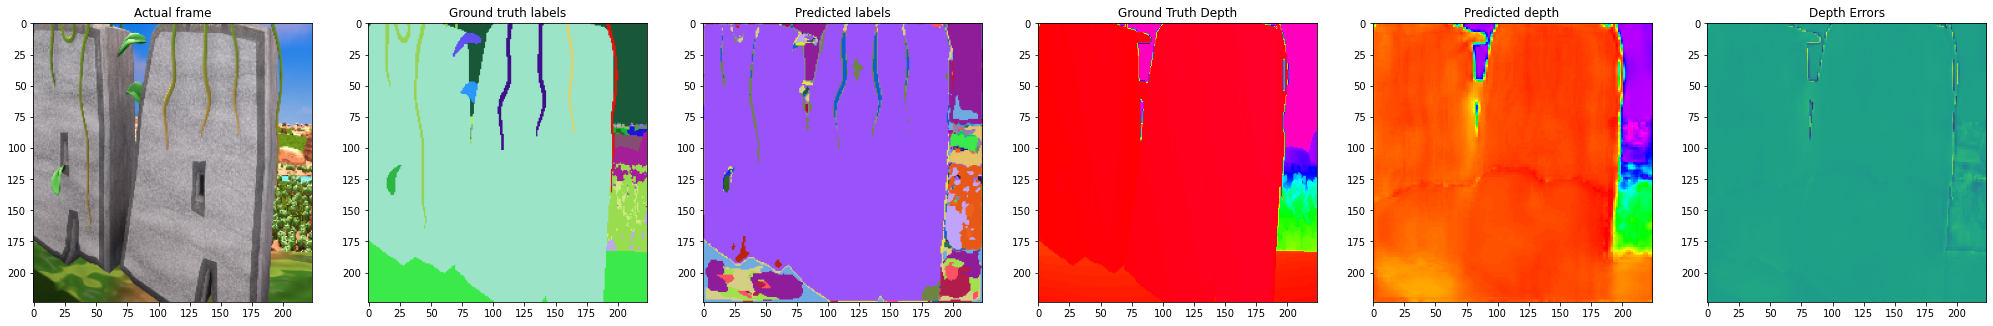

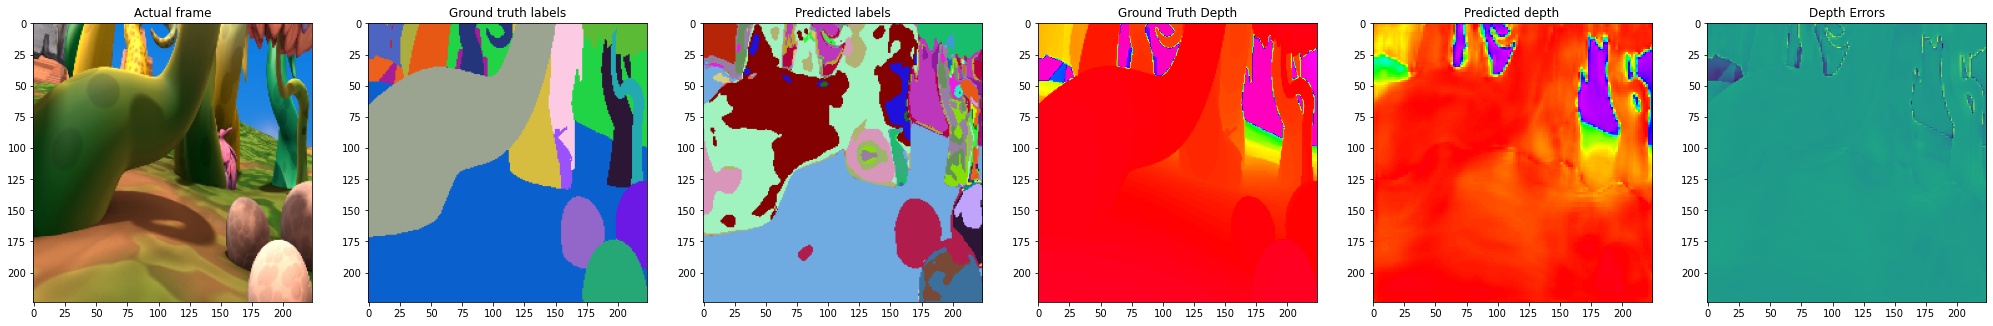

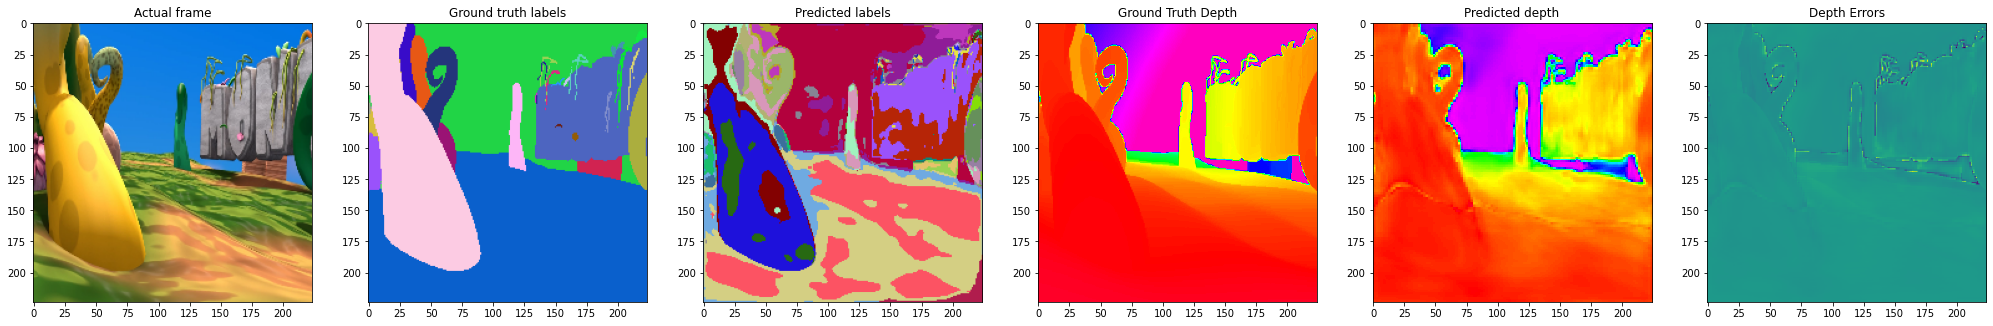

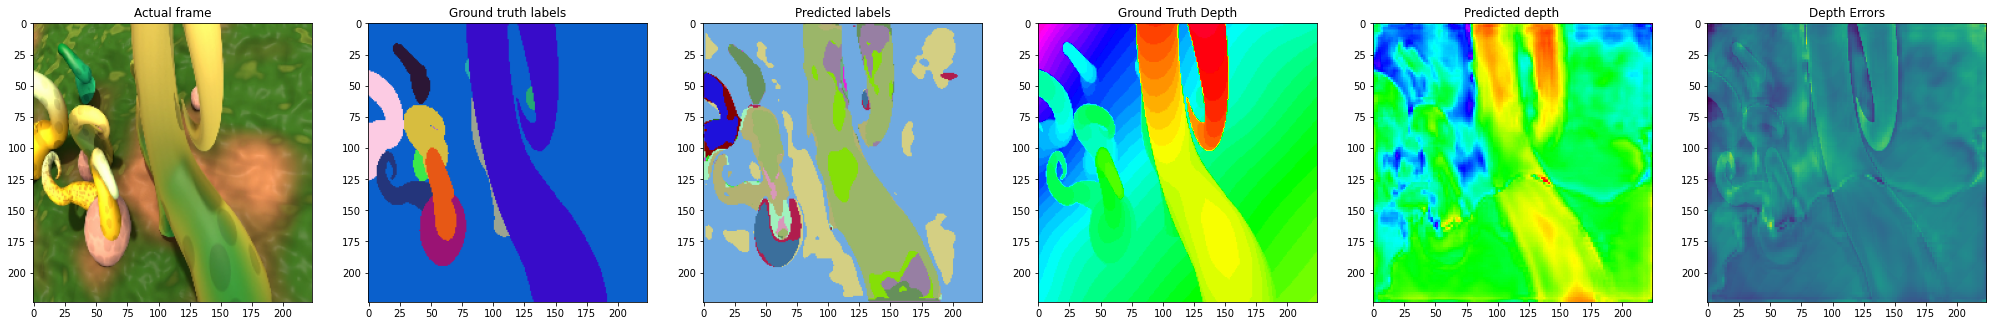

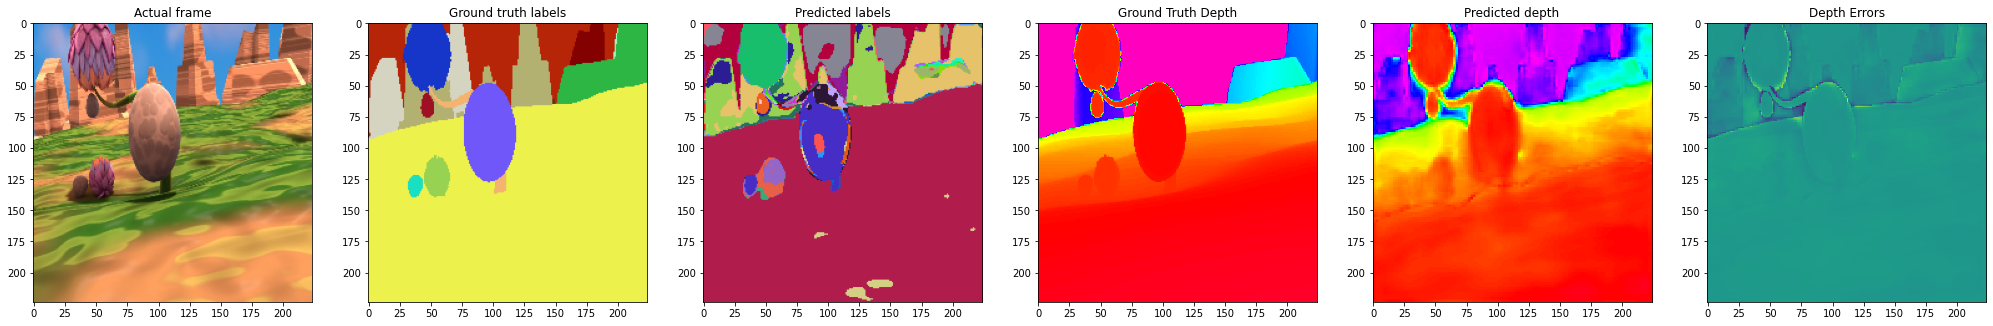

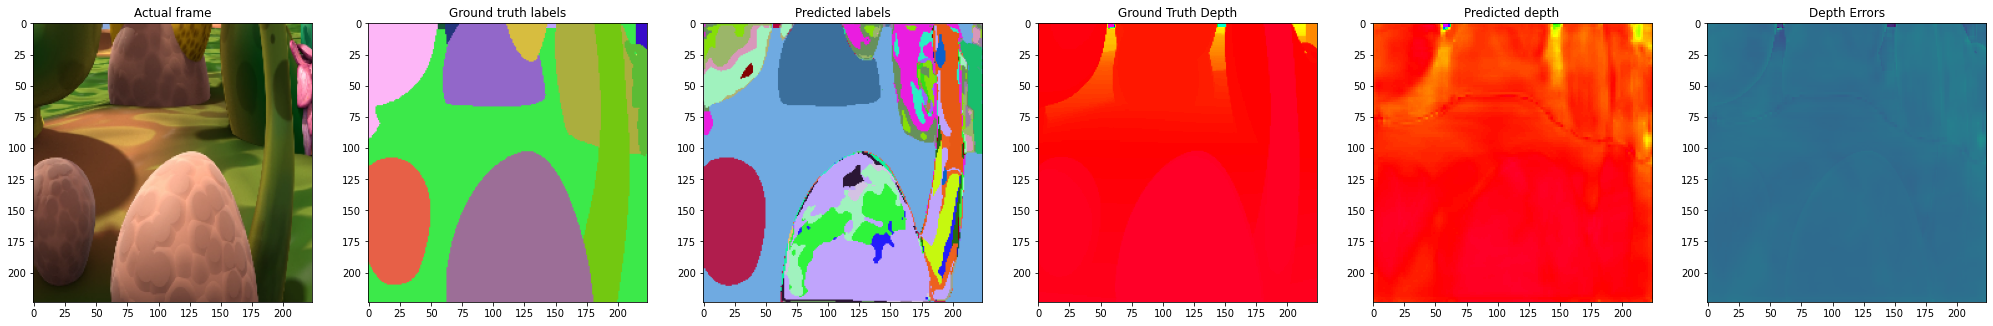

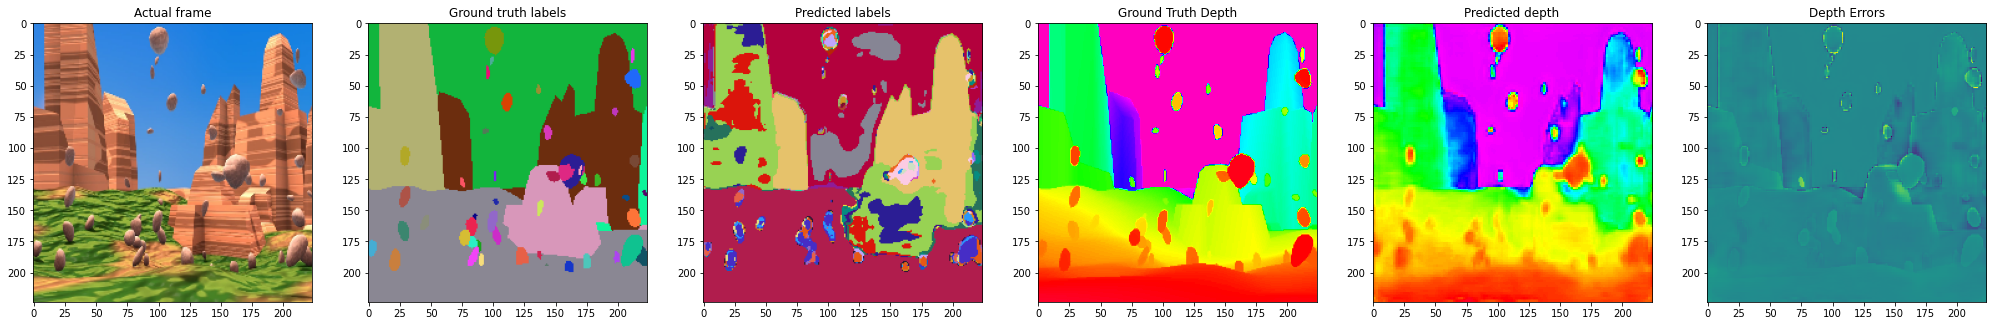

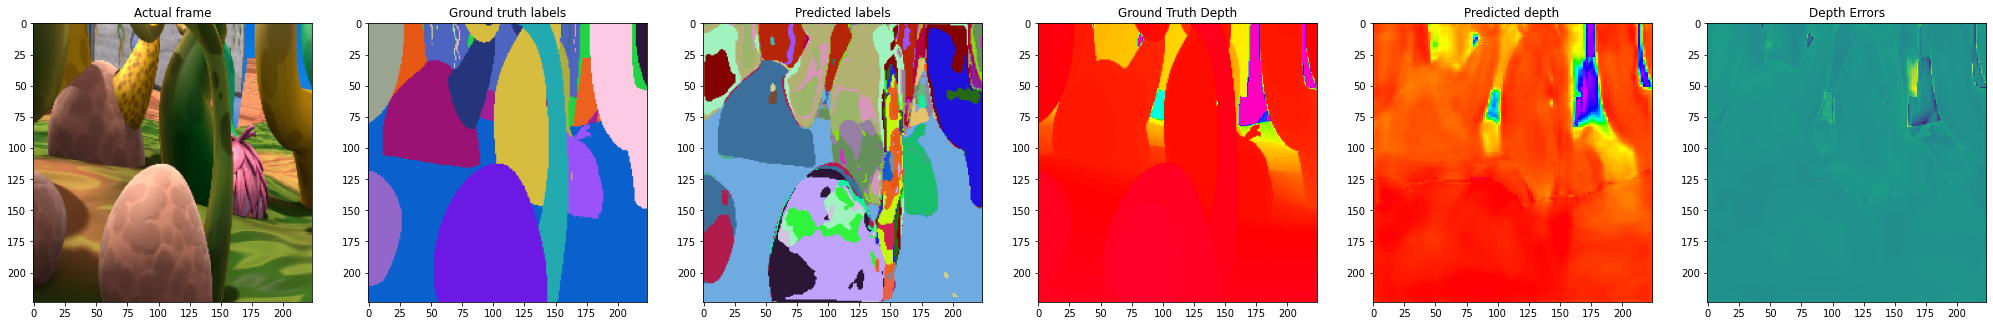

In [23]:
depth_errors =[]
for i in range(0,8):
    colourmap = 'gist_rainbow'
    #print(batch_mask[i])
    fig = plt.figure(figsize=(35,12))
    
    ax1 = fig.add_subplot(1,6,1)
    ax1.imshow(left_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(False)
    
    
    ax2 = fig.add_subplot(1,6,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(np.asarray((mask[i]))))
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,6,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[0][i]))
    ax3.grid(False) 
    
    
    ax4 = fig.add_subplot(1,6,4)
    ax4.set_title('Ground Truth Depth')
    ax4.grid(False)
    ax4= plt.imshow(depth[i],cmap = colourmap)
    
    
    ax5 = fig.add_subplot(1,6,5)
    ax5.set_title('Predicted depth')
    ax5.grid(False)
    ax5 = imshow(pred_all[2][i],cmap = colourmap)
    
    
    ax6 = fig.add_subplot(1,6,6)
    ax6.set_title('Depth Errors')
    ax6 = imshow(pred_all[2][i] - depth[i])

    depth_errors.append(pred_all[2][i]-depth[i])
    
